# Fine Tune the Dataset

There are still some anomalies after smoothing requiring further fine tune. Anomaly indexes are stored in the `FineTunedLog/anomaly_index.json`.

## Import Dependencies

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Some Global Configuration Variables

In [60]:
ROOT="AnomalyRemovedLog"
SMOOTHED_NAME="smoothed.csv"
OUTPUT="FineTunedLog"
OUTPUT_NAME="tuned.csv"

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

## Read and Plot Anomaly Removed Log

,timestamp,num_request,size
0,1998-06-09 00:00:00,9521,50856750
1,1998-06-09 00:01:00,9009,41659434
2,1998-06-09 00:02:00,9441,45436170
3,1998-06-09 00:03:00,9636,46345904
4,1998-06-09 00:04:00,10333,50035640
...,...,...,...
50395,1998-07-13 23:55:00,6756,29948383
50396,1998-07-13 23:56:00,6862,29386925
50397,1998-07-13 23:57:00,6696,38582518
50398,1998-07-13 23:58:00,6524,31089066


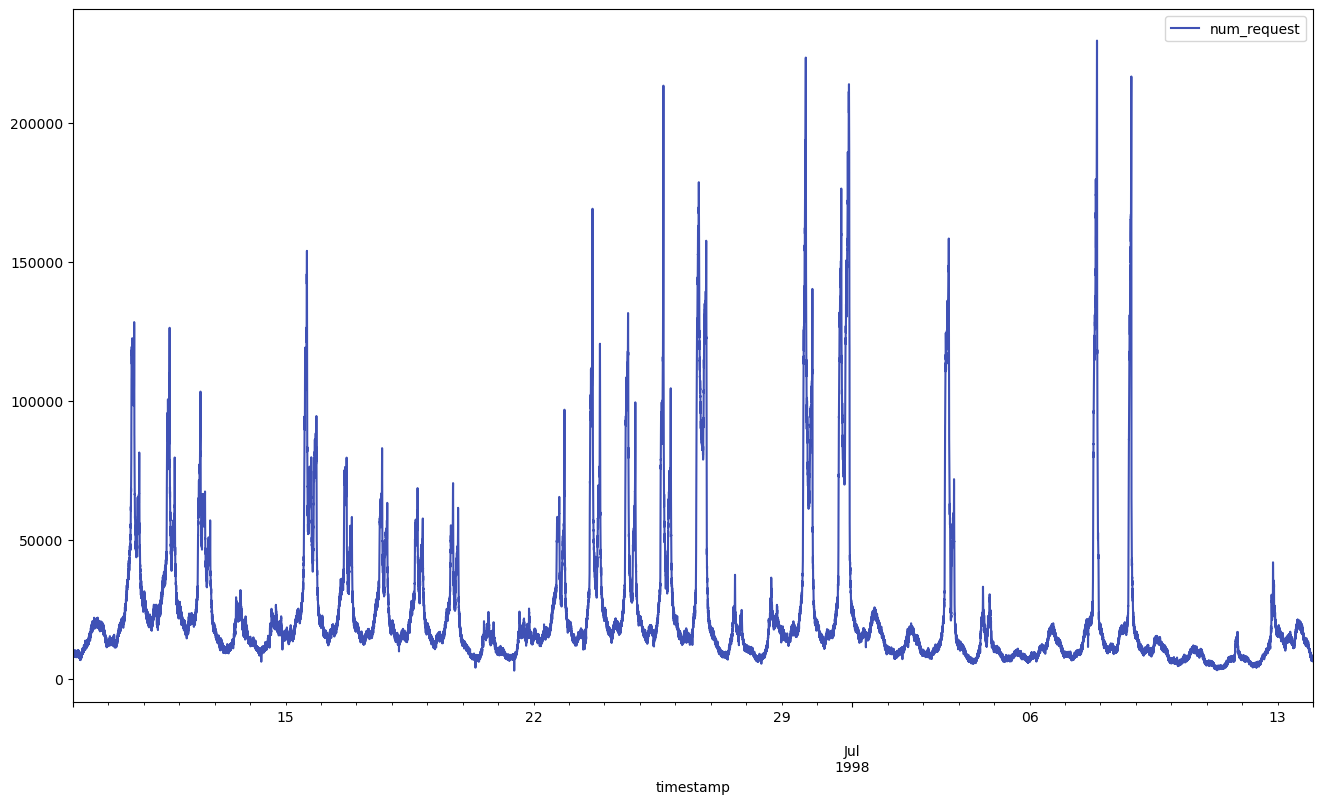

In [61]:
def read_and_plot(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    df.plot(x="timestamp", y="num_request", figsize=(16, 9), color="#3F51B5", label="num_request")  # material color indigo
    return df


read_and_plot(os.path.join(ROOT, SMOOTHED_NAME))

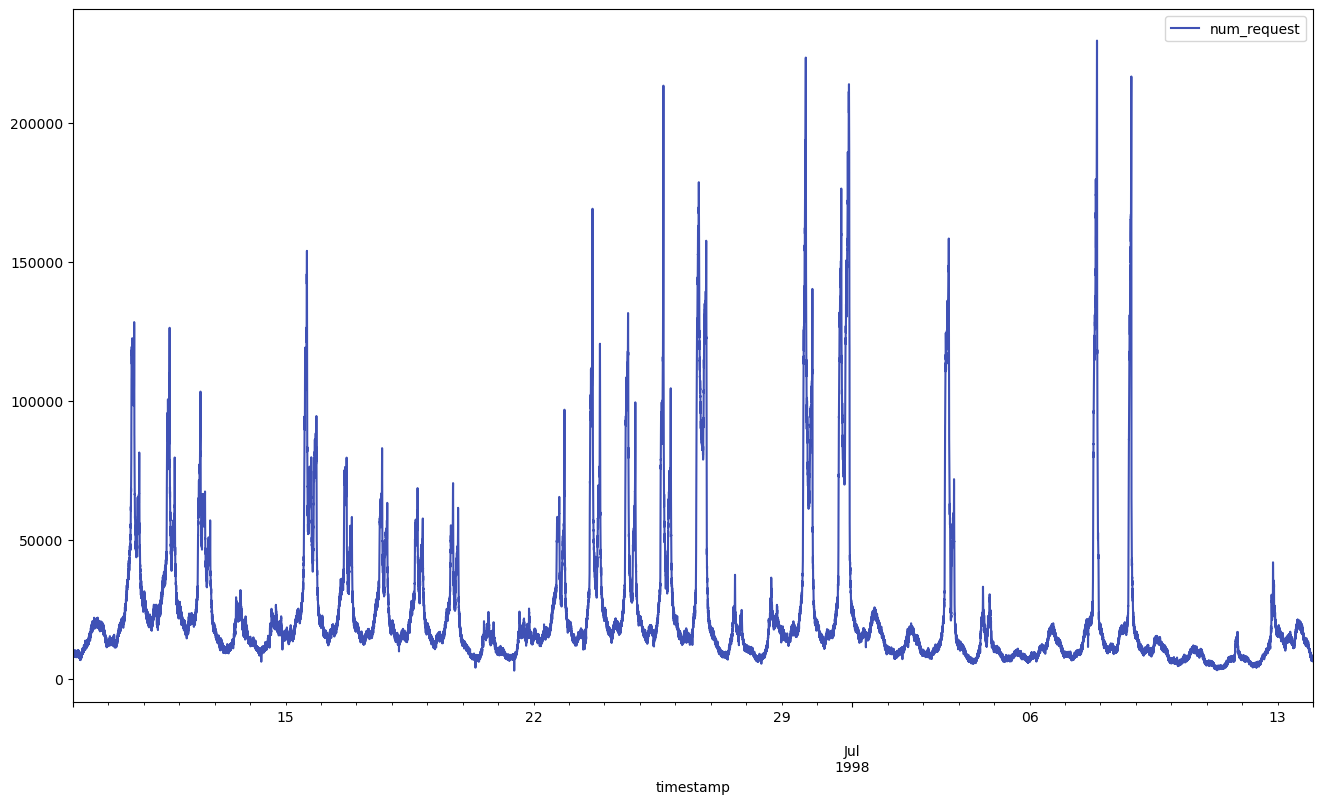

In [62]:
df = read_and_plot(os.path.join(ROOT, SMOOTHED_NAME))
num_request = df["num_request"].to_numpy()
i=0
with open(os.path.join(OUTPUT, "anomaly_index.json"), "r") as f:
    anomaly_index_list = json.load(f)
while i < (len(anomaly_index_list)):
    anomaly_index = anomaly_index_list[i]
    offset = 0
    while i+offset+1 < len(anomaly_index_list) and anomaly_index+offset+1 == anomaly_index_list[i+offset+1]:
        offset += 1
    anomaly_index_end = anomaly_index_list[i+offset]
    for j in range(anomaly_index, anomaly_index_end+1):
        num_request[j] = np.mean([num_request[anomaly_index-1], num_request[anomaly_index_end+1]])
    i += offset+1
plt.plot(num_request)

In [63]:
def further_fine_tune(num_requests: np.ndarray):
    num_requests_copy = num_requests.copy()
    with open(os.path.join(OUTPUT, "anomaly_index.json"), "r") as f:
        anomaly_index_list = json.load(f)
    i = 0
    while i < (len(anomaly_index_list)):
        anomaly_index = anomaly_index_list[i]
        offset = 0
        while i+offset+1 < len(anomaly_index_list) and anomaly_index+offset+1 == anomaly_index_list[i+offset+1]:
            offset += 1
        anomaly_index_end = anomaly_index_list[i+offset]
        for j in range(anomaly_index, anomaly_index_end+1):
            num_requests_copy[j] = np.mean([num_requests_copy[anomaly_index-1], num_requests_copy[anomaly_index_end+1]])
        i += offset+1
    return num_requests_copy

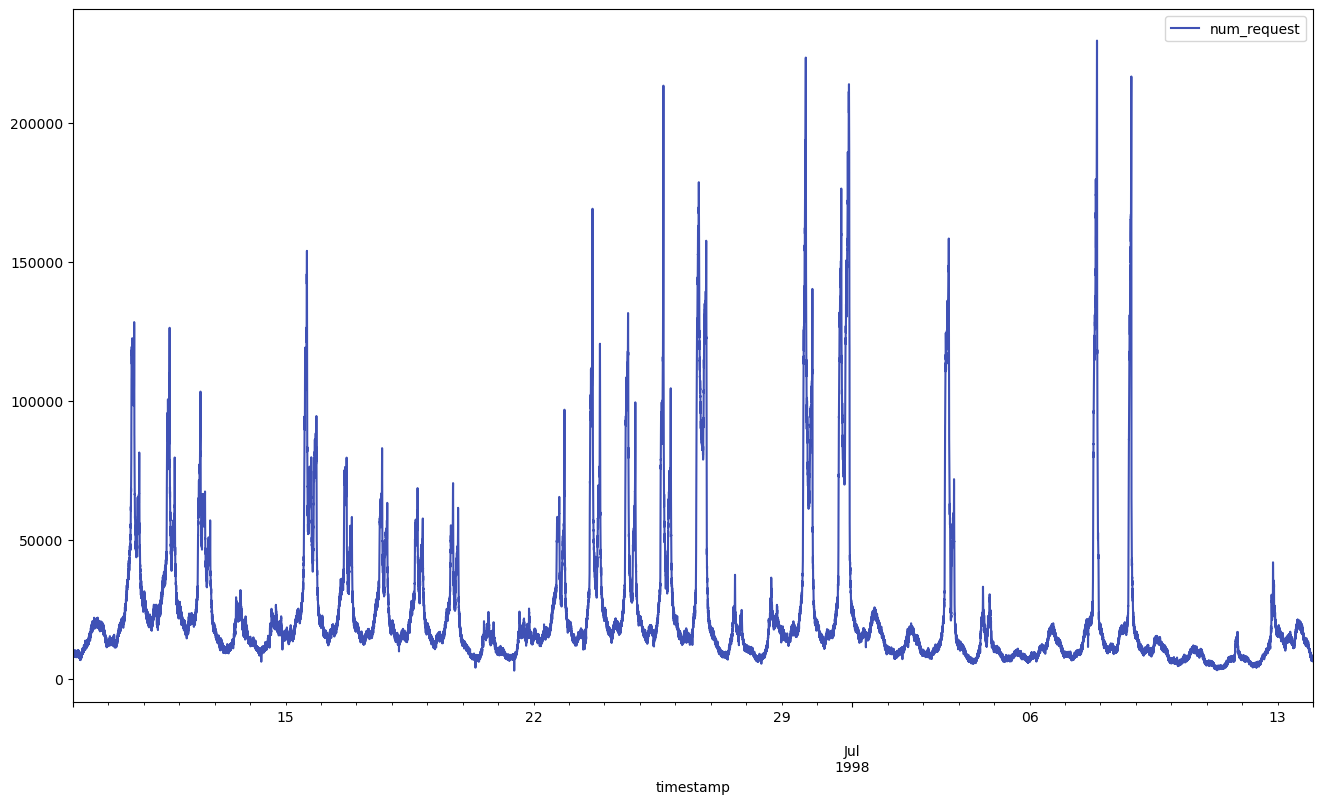

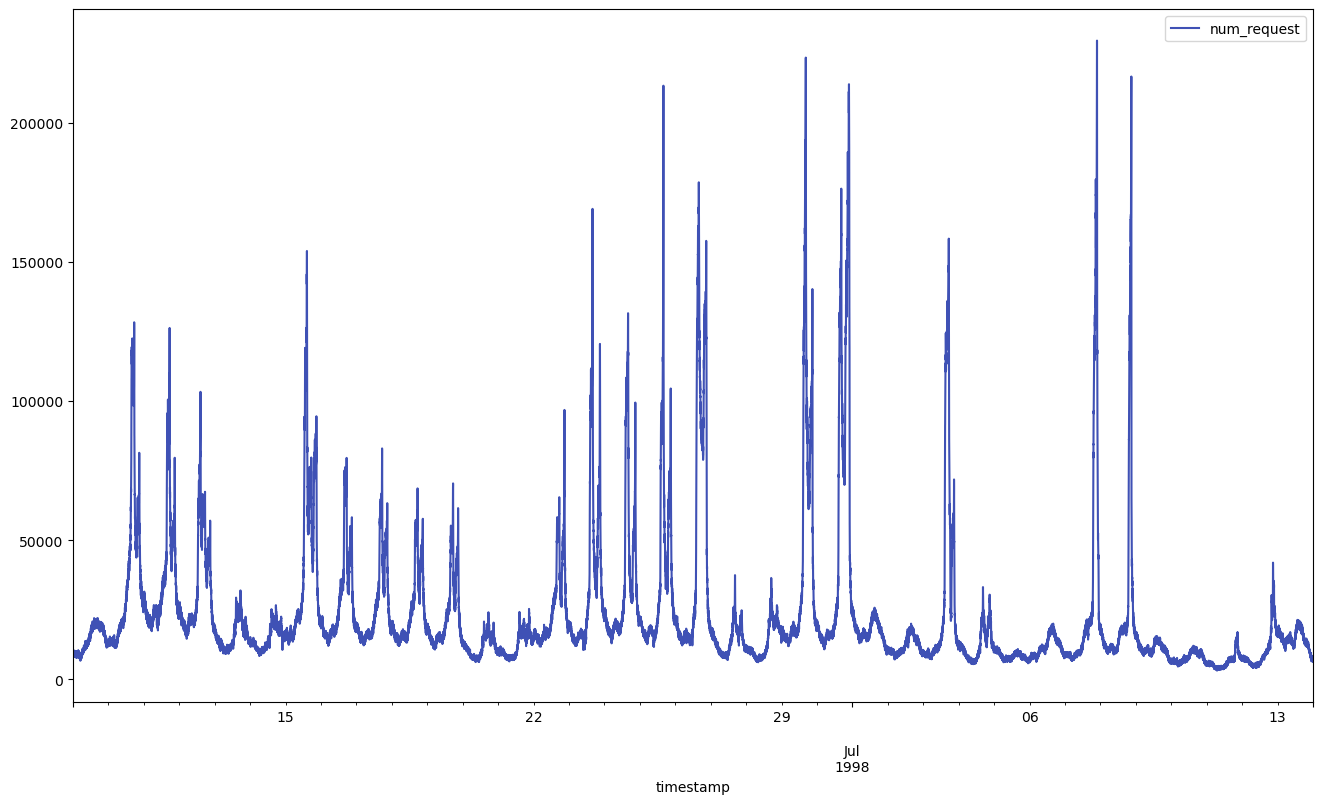

In [64]:
if __name__ == "__main__":
    df = read_and_plot(os.path.join(ROOT, SMOOTHED_NAME))
    fine_tuned_num_requests = further_fine_tune(df["num_request"].to_numpy())
    df["num_request"] = fine_tuned_num_requests
    df.to_csv(os.path.join(OUTPUT, OUTPUT_NAME), index=False)
    df.plot(x="timestamp", y="num_request", figsize=(16, 9), color="#3F51B5", label="num_request")  # material color indigo